# 🧐 Text Sentiment Classifcation

## References
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
- https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
- https://keras.io/api/
- https://pieriantraining.com/tensorflow-lstm-example-a-beginners-guide/
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- https://www.chatgpt.com/ (debugging and testing help, also helped me optimize training to get better results)

## 📚 Problem Statement
In this project, we are trying to build a classifier to analyze the sentiment of reviews. The dataset contains two folders of reviews, one for positive reviews and the other for negative reviews. The goal is to build a classifier that can predict the sentiment of a given review.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Embedding, Conv1D, MaxPooling1D, LSTM, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import string
from tqdm import tqdm

## 📦 Data Preprocessing

Here we load the data from its respective folders and create a dataframe out of it. We add a column for the sentiment of the review, where 1 represents a positive review and 0 represents a negative review. We then split the data into train and test sets based on its name.

In [2]:
tqdm.pandas()

pos_files = glob.glob("../data/pos/*.txt")
neg_files = glob.glob("../data/neg/*.txt")

files_df = pd.DataFrame({
    'filename': pos_files + neg_files,
    'label': [1] * len(pos_files) + [0] * len(neg_files)  # using 1 and 0 as labels for positive and negative for sigmoid activation
})

def read_and_clean(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

files_df['text'] = files_df['filename'].progress_apply(read_and_clean)

files_df['cv_number'] = files_df['filename'].str.extract(r'cv(\d+)_').astype(int)


train_df = files_df[(files_df['cv_number'] >= 0) & (files_df['cv_number'] < 700)]
test_df = files_df[(files_df['cv_number'] >= 700) & (files_df['cv_number'] < 1000)]

display(train_df['label'].value_counts())
display(test_df['label'].value_counts())

display(train_df.head())

100%|██████████| 2000/2000 [00:00<00:00, 32660.58it/s]


label
1    700
0    700
Name: count, dtype: int64

label
1    300
0    300
Name: count, dtype: int64

,filename,label,text,cv_number
1,../data/pos/cv034_29647.txt,1,plot derek zoolander is a male model \nhe is...,34
4,../data/pos/cv253_10077.txt,1,good will hunting is two movies in one an ...,253
5,../data/pos/cv147_21193.txt,1,the story of us a rob reiner film is the sec...,147
7,../data/pos/cv686_13900.txt,1,the fighting sullivans contains a major plo...,686
8,../data/pos/cv410_24266.txt,1,george little jonathan lipnicki wants a litt...,410


## 🧮 Counting the number of (unique) words in each review

In [3]:
words =[]
review_lengths = []
for index,row in files_df.iterrows():
    to_append = row['text'].split()
    review_lengths.append(len(to_append))
    for word in to_append:
        words.append(word)

unique_words = set(words)
print(f"Unique words in the dataset: {len(unique_words)}")
print(f"Average length of a review: {np.mean(review_lengths)}")
print(f"Standard Deviation of a review: {np.std(review_lengths)}")

Unique words in the dataset: 47567
Average length of a review: 646.6335
Standard Deviation of a review: 285.75678675711276


## 📊 Distribution of the number of words in each review

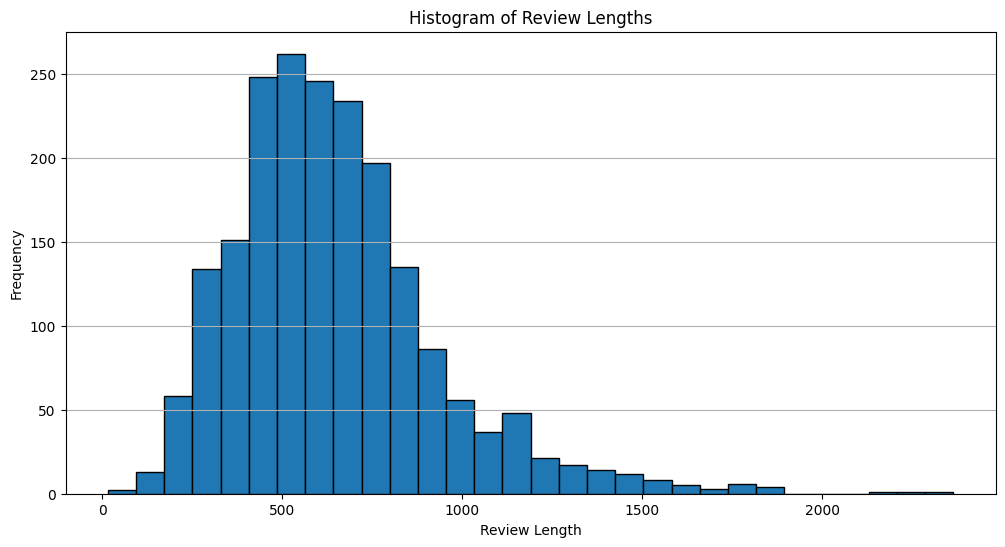

In [4]:
plt.figure(figsize=(12, 6))
plt.grid(True, axis='y')
plt.hist(review_lengths, bins=30, edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

## 🍪 Tokenization

In [5]:
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='UNK')
tokenizer.fit_on_texts(files_df['text'])

files_df['tokenized'] = tokenizer.texts_to_sequences(files_df['text'])

In [6]:
files_df[['tokenized','text']].head(10)

,tokenized,text
0,"[2524, 181, 2, 4241, 7, 289, 27, 5, 2, 63, 373...",assume nothing \nthe phrase is perhaps one of...
1,"[99, 2294, 1, 7, 3, 1308, 2024, 18, 7, 72, 79,...",plot derek zoolander is a male model \nhe is...
2,"[19, 174, 692, 3, 896, 5, 2, 202, 1, 48, 39, 1...",i actually am a fan of the original 1961 or so...
3,"[3, 28, 186, 69, 11, 1050, 2000, 47, 11, 2, 10...",a movie thats been as highly built up as the t...
4,"[62, 66, 1977, 7, 80, 102, 8, 27, 25, 2888, 15...",good will hunting is two movies in one an ...
5,"[2, 67, 5, 130, 3, 1521, 1, 16, 7, 2, 376, 28,...",the story of us a rob reiner film is the sec...
6,"[1, 1161, 132, 9, 34, 69, 1928, 30, 38, 5, 2, ...",anastasia contains something that has been lac...
7,"[2, 1335, 1, 1161, 3, 455, 99, 1095, 8, 2, 173...",the fighting sullivans contains a major plo...
8,"[609, 95, 2027, 1, 285, 3, 95, 583, 82, 409, 4...",george little jonathan lipnicki wants a litt...
9,"[142, 36, 749, 106, 457, 36, 1, 121, 9, 19, 12...",before you read my review you gotta know that...


## 📏 Padding

### Setting the maximum length of the reviews

In [7]:
length_70th_percentile = np.percentile(review_lengths, 70)
L = int(length_70th_percentile)
print(f"70th percentile review length: {L}")

70th percentile review length: 739


### Padding the reviews

In [8]:
files_df['padded'] = pad_sequences(files_df['tokenized'], maxlen=L, padding='pre', truncating='pre').tolist()

*** 
### Sidenote: 

After some experimentation, and research I found that padding and truncating the reviews with 'pre' compared to 'post' yielded better results. Especially when using the LSTM model.
***

## 💬 Word Embeddings

In [9]:
X = np.array(files_df['padded'].tolist())

embedding_dim = 32
embedding_model = Sequential()
embedding_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=L))

embedding_model.compile(optimizer='adam', loss='binary_crossentropy')

files_df['embedded'] = embedding_model.predict(X).tolist()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


/Users/adhamelfawal/anaconda3/envs/dsciproj/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Flatten the Embedings

In [10]:
files_df['embedded'] = files_df['embedded'].apply(lambda x: np.array(x).flatten())

### Sanity Check

In [11]:
files_df[['text','padded','embedded']].head()

,text,padded,embedded
0,assume nothing \nthe phrase is perhaps one of...,"[1, 1198, 4242, 3, 3779, 3682, 2292, 364, 1, 2...","[0.03239821270108223, 0.003620721399784088, -0..."
1,plot derek zoolander is a male model \nhe is...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.012661494314670563, -0.03932018205523491, ..."
2,i actually am a fan of the original 1961 or so...,"[9, 1863, 285, 6, 129, 6, 6, 276, 43, 1, 37, 1...","[-0.028877854347229004, 0.03281095251441002, 0..."
3,a movie thats been as highly built up as the t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.012661494314670563, -0.03932018205523491, ..."
4,good will hunting is two movies in one an ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.012661494314670563, -0.03932018205523491, ..."


## 🧠 Model Building

In [12]:
# Need to resplit train and test data after embeddings
train_df = files_df[(files_df['cv_number'] >= 0) & (files_df['cv_number'] < 700)]
test_df = files_df[(files_df['cv_number'] >= 700) & (files_df['cv_number'] < 1000)]

train_df = train_df.sample(frac=1).reset_index(drop=True) # shuffle the data (not necessary but good practice)

display(train_df.head()) # Sanity Check

X_train = np.array(train_df['padded'].tolist())
y_train = np.array(train_df['label'].tolist())
X_test = np.array(test_df['padded'].tolist())
y_test = np.array(test_df['label'].tolist())

,filename,label,text,cv_number,tokenized,padded,embedded
0,../data/neg/cv050_12128.txt,0,my giant is two movies for the price of one b...,50,"[106, 799, 7, 80, 102, 13, 2, 1647, 5, 27, 17,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.012661494314670563, -0.03932018205523491, ..."
1,../data/pos/cv394_5137.txt,1,defending your life is an imaginative vision o...,394,"[1, 171, 96, 7, 25, 4036, 2009, 5, 2, 1, 30, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.012661494314670563, -0.03932018205523491, ..."
2,../data/pos/cv576_14094.txt,1,as fairy tales go cinderella has to be one of...,576,"[11, 2521, 3165, 129, 1, 34, 6, 23, 27, 5, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.012661494314670563, -0.03932018205523491, ..."
3,../data/pos/cv090_0042.txt,1,warning anyone offended by blatant leering m...,90,"[2269, 324, 4839, 22, 4016, 1, 1, 91, 152, 147...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.012661494314670563, -0.03932018205523491, ..."
4,../data/pos/cv662_13320.txt,1,hollywood has a 750 \nbatting average with el...,662,"[268, 34, 3, 1, 1, 1228, 12, 1, 3627, 1, 173, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.012661494314670563, -0.03932018205523491, ..."


### MLP Model

In [13]:
embedding_dim = 32
model = Sequential([
    Input(shape=(L,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train, 
    epochs=2, 
    batch_size=10, 
    # validation_data=(X_test, y_test),
)

train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 739, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     1,182,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,347,601 (5.14 MB)

 Trainable params: 1,347,601 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5134 - loss: 0.6967
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5916 - loss: 0.6577
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8150 - loss: 0.5048
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6612 - loss: 0.6475 

Train Accuracy: 0.8242856860160828
Test Accuracy: 0.6383333206176758


Train Accuracy: **82.4%**

Test Accuracy: **63.8%**

### CNN Model

In [14]:
embedding_dim = 32
model = Sequential([
    Input(shape=(L,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D( strides=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train, 
    epochs=2, 
    batch_size=10, 
    # validation_data=(X_test, y_test),
)

train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 739, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 737, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 368, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │       588,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,105 (2.89 MB)

 Trainable params: 757,105 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5076 - loss: 0.7022
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5277 - loss: 0.6925
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6566 - loss: 0.6875
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5872 - loss: 0.6882

Train Accuracy: 0.6421428322792053
Test Accuracy: 0.5533333420753479


Train Accuracy: **64.2%**

Test Accuracy: **55.3%**

### LSTM Model

In [15]:
embedding_dim = 32
model = Sequential([
    Input(shape=(L,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(32, dropout=0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
learn_rate = 0.00010
model.compile(optimizer=Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=10, 
    # validation_data=(X_test, y_test),
)

train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 739, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,025 (691.50 KB)

 Trainable params: 177,025 (691.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.5182 - loss: 0.6931
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.5940 - loss: 0.6926
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.6437 - loss: 0.6908
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.6792 - loss: 0.6833
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7401 - loss: 0.6071
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8325 - loss: 0.4035
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8883 - loss: 0.2907
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9243 - loss: 0.2207
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9598 - loss: 0.1428
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9651 - loss: 0.1257
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9830 - loss: 0.0885
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc

Train Accuracy: **98.0%**

Test Accuracy: **80.0%**